In [524]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Reading

In [525]:
data = pd.read_csv('../data/data.csv')

In [526]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     15 non-null     float64
 1   lon     15 non-null     float64
 2   date    15 non-null     object 
 3   Pb      15 non-null     float64
 4   As      15 non-null     float64
 5   Hg      15 non-null     float64
 6   Cr      15 non-null     float64
dtypes: float64(6), object(1)
memory usage: 972.0+ bytes


In [527]:
POLLUTANTS = ["Pb", "As", "Hg", "Cr"]
# mg/L
GUIDES = {
    "Pb": 0.05,
    "As": 0.01,
    "Hg": 0.001,
    "Cr": 0.05
}
STATE_NAMES = ["Safe", "Moderate", "High"]
STATE_THRESHOLDS = [1.0, 3.0]

In [528]:
def compute_max_ratio(row, pollutants, guidelines):
    ratios = []
    for p in pollutants:
        if p in row and pd.notna(row[p]) and guidelines.get(p, None) is not None:
            g = guidelines[p]
            if g == 0:
                continue
            ratios.append(row[p] / g)
    if len(ratios) == 0:
        return np.nan
    return max(ratios)

In [529]:
def ratio_to_state(r, thresholds):
    if pd.isna(r):
        return None
    if r <= thresholds[0]:
        return 0
    elif r <= thresholds[1]:
        return 1
    else:
        return 2

### Data Preprocessing

In [530]:
def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path, parse_dates=['date'])
    # compute max ratio
    df['cd'] = df.apply(lambda r: compute_max_ratio(r, POLLUTANTS, GUIDES), axis=1)
    df['state'] = df['cd'].apply(lambda r: ratio_to_state(r, STATE_THRESHOLDS))
    # drop if state is None
    df = df[df['state'].notna()].copy()
    # year column
    df['year'] = df['date'].dt.year
    return df

In [531]:
data = load_and_preprocess('../data/data.csv')
data

,lat,lon,date,Pb,As,Hg,Cr,cd,state,year
0,22.57,88.36,2016-05-12,0.012,0.008,0.0008,0.040,0.80,0,2016
1,22.57,88.36,2017-06-10,0.020,0.012,0.0015,0.060,1.50,1,2017
2,22.57,88.36,2018-07-15,0.025,0.018,0.0020,0.080,2.00,1,2018
3,22.57,88.36,2019-08-20,0.030,0.020,0.0025,0.090,2.50,1,2019
4,22.57,88.36,2020-09-25,0.040,0.025,0.0030,0.100,3.00,1,2020
5,22.60,88.40,2016-04-11,0.008,0.006,0.0005,0.030,0.60,0,2016
6,22.60,88.40,2017-06-18,0.010,0.007,0.0006,0.035,0.70,0,2017
7,22.60,88.40,2018-07-22,0.015,0.009,0.0007,0.038,0.90,0,2018
8,22.60,88.40,2019-08-27,0.018,0.010,0.0009,0.042,1.00,0,2019
9,22.60,88.40,2020-09-30,0.020,0.012,0.0010,0.045,1.20,1,2020


### Aggregate multiple samples in same (cell, year) to single state.
       agg_method: 'majority' or 'mean_ratio' (maps mean ratio back to state)

In [532]:
def aggregate_cell_year(df, agg_method="majority"):
    grouped = df.groupby(['lat','lon','year'])
    agg_rows = []
    for (clat, clon, year), group in grouped:
        if agg_method == "majority":
            most = group['state'].mode()
            if len(most) == 0:
                state = int(group['state'].iloc[0])
            else:
                state = int(most.iloc[0])
        else:
            mean_ratio = group['max_ratio'].mean()
            state = ratio_to_state(mean_ratio, STATE_THRESHOLDS)
        agg_rows.append({
            'lat': clat,
            'lon': clon,
            'year': int(year),
            'state': int(state)
        })
    agg_df = pd.DataFrame(agg_rows)
    return agg_df

In [533]:
data = aggregate_cell_year(data)
data

,lat,lon,year,state
0,22.57,88.36,2016,0
1,22.57,88.36,2017,1
2,22.57,88.36,2018,1
3,22.57,88.36,2019,1
4,22.57,88.36,2020,1
5,22.60,88.40,2016,0
6,22.60,88.40,2017,0
7,22.60,88.40,2018,0
8,22.60,88.40,2019,0
9,22.60,88.40,2020,1


### Trend of a particular locality over the years
        Return dict: cell_id -> sorted list of (year, state)

In [534]:
def build_sequences(agg_df):
    seqs = {}
    for (lat, lon), group in agg_df.groupby(['lat','lon']):
        group_sorted = group.sort_values('year')
        seqs[(lat,lon)] = list(zip(group_sorted['year'].tolist(), group_sorted['state'].tolist()))
    return seqs

In [535]:
seq = build_sequences(data)
seq

{(np.float64(22.57), np.float64(88.36)): [(2016, 0),
  (2017, 1),
  (2018, 1),
  (2019, 1),
  (2020, 1)],
 (np.float64(22.6), np.float64(88.4)): [(2016, 0),
  (2017, 0),
  (2018, 0),
  (2019, 0),
  (2020, 1)],
 (np.float64(22.63), np.float64(88.42)): [(2016, 0),
  (2017, 0),
  (2018, 0),
  (2019, 0),
  (2020, 0)]}

### Transition Matrix

In [536]:
def transition_matrix_global (seq, n_states):
    # initiate the transition matrix with 0
    T = np.zeros((n_states, n_states), dtype=float)
    
    # check for the trends in a particular location
    for cell, yrs in seq.items():
        
        for i in range(len(yrs)-1): 
            year_t, s_t = yrs[i] 
            year_t1, s_t1 = yrs[i+1]
            
            if(year_t + 1 == year_t1):
                T[s_t, s_t1] += 1
    
    # Laplace smoothing
    T = T + 1.2
    row_sums = T.sum(axis=1, keepdims=True)
    T = T / row_sums
    return T 

In [537]:
def transition_matrix_local (seq, n_states):
    local_T = {}
    for cell, yrs in seq.items():
        T = np.zeros((n_states, n_states), dtype=float)
        for i in range(len(yrs)-1):
            year_t, s_t = yrs[i]
            year_t1, s_t1 = yrs[i+1]
            if year_t1 == year_t + 1:  # only strict consecutive years
                T[s_t, s_t1] += 1

        # Laplace smoothing
        T = T + 1.2
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        local_T[cell] = T
    return local_T

In [538]:
global_transition_matrix = transition_matrix_global(seq, 3) 
local_transition_matrix = transition_matrix_local(seq, 3)
global_transition_matrix, local_transition_matrix

(array([[0.65079365, 0.25396825, 0.0952381 ],
        [0.18181818, 0.63636364, 0.18181818],
        [0.33333333, 0.33333333, 0.33333333]]),
 {(np.float64(22.57),
   np.float64(88.36)): array([[0.26086957, 0.47826087, 0.26086957],
         [0.18181818, 0.63636364, 0.18181818],
         [0.33333333, 0.33333333, 0.33333333]]),
  (np.float64(22.6),
   np.float64(88.4)): array([[0.55263158, 0.28947368, 0.15789474],
         [0.33333333, 0.33333333, 0.33333333],
         [0.33333333, 0.33333333, 0.33333333]]),
  (np.float64(22.63),
   np.float64(88.42)): array([[0.68421053, 0.15789474, 0.15789474],
         [0.33333333, 0.33333333, 0.33333333],
         [0.33333333, 0.33333333, 0.33333333]])})

### Prediction 

In [539]:
def predict_future (current_state, n_yrs, lat, lon):
    T = local_transition_matrix.get((lat, lon), global_transition_matrix)
    p = np.zeros(3, dtype=float)
    p[current_state] = 1
    
    predictions = []
    predictions.append(p.copy())
    for i in range(n_yrs):
        p = p @ global_transition_matrix
        predictions.append(p.copy())
        
    return np.array(predictions)
        

In [540]:
def get_all_preds():
    preds = []
    for _, row in data.iterrows():
        state = int(row['state'])
        lat = float(row['lat'])
        lon = float(row['lon'])
        pred = predict_future(state, 5, lat, lon)
        pred = pred.flatten()
        preds.append(pred)
    return preds

all_preds = get_all_preds()
all_preds

[array([1.        , 0.        , 0.        , 0.65079365, 0.25396825,
        0.0952381 , 0.50145445, 0.35864312, 0.13990243, 0.43818536,
        0.40221509, 0.15959955, 0.41149811, 0.42044008, 0.16806181,
        0.40026461, 0.42808084, 0.17165455]),
 array([0.        , 1.        , 0.        , 0.18181818, 0.63636364,
        0.18181818, 0.29463466, 0.51174078, 0.19362456, 0.34933166,
        0.4650226 , 0.18564574, 0.3737743 , 0.44652454, 0.17970116,
        0.38433661, 0.43897917, 0.17668422]),
 array([0.        , 1.        , 0.        , 0.18181818, 0.63636364,
        0.18181818, 0.29463466, 0.51174078, 0.19362456, 0.34933166,
        0.4650226 , 0.18564574, 0.3737743 , 0.44652454, 0.17970116,
        0.38433661, 0.43897917, 0.17668422]),
 array([0.        , 1.        , 0.        , 0.18181818, 0.63636364,
        0.18181818, 0.29463466, 0.51174078, 0.19362456, 0.34933166,
        0.4650226 , 0.18564574, 0.3737743 , 0.44652454, 0.17970116,
        0.38433661, 0.43897917, 0.17668422]),


### Visualisation

In [541]:
def plot_state_probs_over_time(dist, title="State probabilities over time", n_yrs = 5):
    years = np.arange(0, n_yrs + 1)
    for i, name in enumerate(STATE_NAMES):
        plt.plot(years, dist[: ,i], marker='o', label=name)
    plt.xlabel("Years ahead (0 = now)")
    plt.ylabel("Probability")
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()


[[0.         1.         0.        ]
 [0.18181818 0.63636364 0.18181818]
 [0.29463466 0.51174078 0.19362456]
 [0.34933166 0.4650226  0.18564574]
 [0.3737743  0.44652454 0.17970116]
 [0.38433661 0.43897917 0.17668422]]


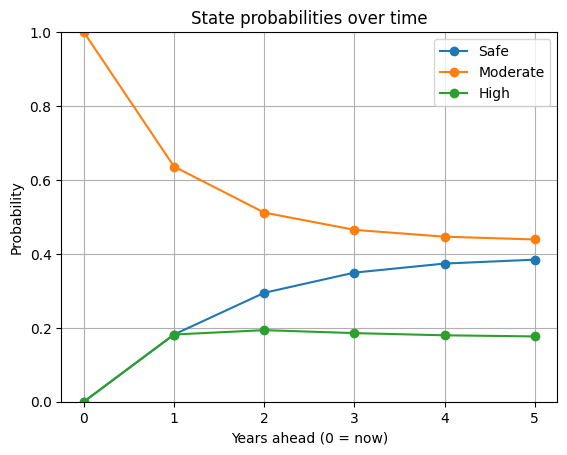

In [542]:
preds = predict_future(1,5, '22.54', '88.74')
print(preds)
plot_state_probs_over_time(preds, n_yrs=5)

### Model training

In [543]:
X = data
Y = all_preds
X, Y

(      lat    lon  year  state
 0   22.57  88.36  2016      0
 1   22.57  88.36  2017      1
 2   22.57  88.36  2018      1
 3   22.57  88.36  2019      1
 4   22.57  88.36  2020      1
 5   22.60  88.40  2016      0
 6   22.60  88.40  2017      0
 7   22.60  88.40  2018      0
 8   22.60  88.40  2019      0
 9   22.60  88.40  2020      1
 10  22.63  88.42  2016      0
 11  22.63  88.42  2017      0
 12  22.63  88.42  2018      0
 13  22.63  88.42  2019      0
 14  22.63  88.42  2020      0,
 [array([1.        , 0.        , 0.        , 0.65079365, 0.25396825,
         0.0952381 , 0.50145445, 0.35864312, 0.13990243, 0.43818536,
         0.40221509, 0.15959955, 0.41149811, 0.42044008, 0.16806181,
         0.40026461, 0.42808084, 0.17165455]),
  array([0.        , 1.        , 0.        , 0.18181818, 0.63636364,
         0.18181818, 0.29463466, 0.51174078, 0.19362456, 0.34933166,
         0.4650226 , 0.18564574, 0.3737743 , 0.44652454, 0.17970116,
         0.38433661, 0.43897917, 0.1766842

In [544]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [545]:
rf_reg = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42))
rf_reg.fit(X, Y)

,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [546]:
Y_pred = rf_reg.predict(X)
Y_pred

array([[0.905     , 0.095     , 0.        , 0.61796537, 0.29220779,
        0.1025974 , 0.48697707, 0.3731874 , 0.14554325, 0.42929999,
        0.40535547, 0.16207394, 0.40866883, 0.42265726, 0.16928394,
        0.39867181, 0.42889821, 0.17208207],
       [0.        , 1.        , 0.        , 0.18181818, 0.63636364,
        0.18138528, 0.29566876, 0.5109753 , 0.19335595, 0.34933166,
        0.4650226 , 0.18564574, 0.37396292, 0.44652454, 0.17970116,
        0.38433661, 0.43897917, 0.17665907],
       [0.        , 1.        , 0.        , 0.18181818, 0.63636364,
        0.18138528, 0.29566876, 0.5109753 , 0.19335595, 0.34933166,
        0.4650226 , 0.18564574, 0.37396292, 0.44652454, 0.17970116,
        0.38433661, 0.43897917, 0.17665907],
       [0.        , 1.        , 0.        , 0.18181818, 0.63636364,
        0.18181818, 0.29463466, 0.5109753 , 0.19362456, 0.34933166,
        0.4650226 , 0.18564574, 0.3737743 , 0.44652454, 0.17970116,
        0.38433661, 0.43897917, 0.17668422],
    

### Error detection

In [547]:
MSE = mean_squared_error(Y, Y_pred)
MSE

0.00015714362068232202

In [548]:
sample = {
    'lat': 20.20,
    'lon': 21.25,
    'year': 2025,
    'state': 1
}

sample_X = pd.DataFrame([sample])
pred_vec = rf_reg.predict(sample_X)[0]

# Reshape back: (5 years, n_states)
n_states = global_transition_matrix.shape[0]
pred_probs = pred_vec.reshape(6, n_states)
pred_probs

array([[0.        , 1.        , 0.        ],
       [0.18181818, 0.63636364, 0.18181818],
       [0.29463466, 0.51174078, 0.19362456],
       [0.34933166, 0.4650226 , 0.18564574],
       [0.3737743 , 0.44652454, 0.17970116],
       [0.38433661, 0.43897917, 0.17668422]])

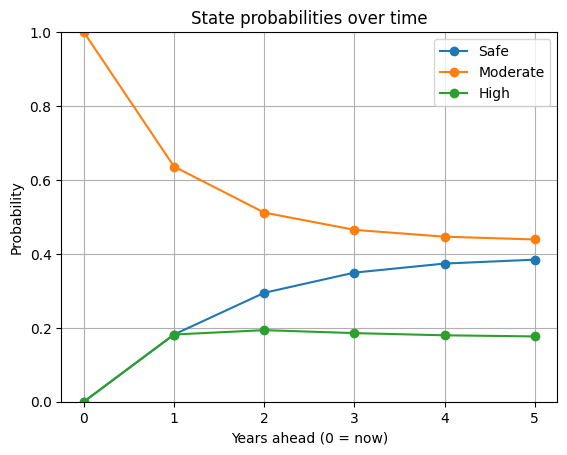

In [549]:
# Visualise
plot_state_probs_over_time(pred_probs, n_yrs=5)

In [550]:
import joblib

In [551]:
joblib.dump(rf_reg, '../model/future_predict_model.joblib')

['../model/future_predict_model.joblib']